In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit

import scipy.ndimage as nd

%matplotlib inline

%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\4D_CT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = r"C:\Users\Bruker\Documents"

std_name = "limestoneV3_1440_1_std.h5"
favg6_name = "limestoneV3_17_55_6favg.h5"
favg12_name = "limestoneV3_17_55_12favg.h5"
favg24_name = "limestoneV3_17_55_24favg.h5"

x1, x2 = 1000, 1001
y1, y2 = 0, 1024
z1, z2 = 0, 1024

key = "gt"


In [3]:
with h5py.File(os.path.join(root, std_name), "r") as f:
    std_slice = np.squeeze(f['std'][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg6_name), "r") as f:
    favg6_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg12_name), "r") as f:
    favg12_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg24_name), "r") as f:
    favg24_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])




rotated_std = nd.rotate(std_slice, 45, reshape=False)
rotated_std = rotated_std[rotated_std.shape[0]//2-512: rotated_std.shape[0]//2+512 , rotated_std.shape[1]//2-512: rotated_std.shape[1]//2+512:]
#RSD: Slightly different mag I think because of geometry readings. Reconstruct again with adjusted geometry

In [159]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects


def add_scalebar(ax, **kwargs):
    if "scalebar_kwargs" not in kwargs:

        size = 25/(0.2*930)*1350

        scale_kwargs = {
            "size": size,
            "label": f"25.0 mm",
            "color": "white",
            "loc": 4,
            "frameon": False,
            "size_vertical": 8,
            "label_top": False,
            # "font_properties": {"size": 12}
        }
    else:
        scale_kwargs = kwargs["scalebar_kwargs"]
    
    scalebar0 = AnchoredSizeBar(ax.transData, **scale_kwargs)
    scalebar0.txt_label._text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black', capstyle="round")])
    ax.add_artist(scalebar0)
    return ax

    

def plot_slice_comparison(favg6, favg12, favg24, title="Slice Comparison", savefig=False):
    choose_formatter(False)
    # fig, axes = plt.subplots(1, 3, figsize=(3*DEFAULT_FIGSIZE[1], DEFAULT_FIGSIZE[1]), tight_layout=True)
    fig = plt.figure(figsize=(3*DEFAULT_FIGSIZE[1], DEFAULT_FIGSIZE[0]))

    gs = GridSpec(1,3, figure=fig, wspace=0, hspace=0.0)
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    axes[0].imshow(favg6, cmap="gray")
    axes[0].set_title("6 favg")
    axes[1].imshow(favg12, cmap="gray")
    axes[1].set_title("12 favg")
    axes[2].imshow(favg24, cmap="gray")
    axes[2].set_title("24 favg")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)

    
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf" )

    plt.show()

def plot_slice_grid(imgs:list, titles:list, suptitle=None, savefile=None, savefig=False, fig=None):

    choose_formatter(False)
    def grids(n):

        if n<=3:
            return 1, n
        n_sqrt = np.sqrt(n)
        if n_sqrt % 1 == 0:
            return int(n_sqrt), int(n_sqrt)
        else:
            assert n % 3 == 0
            return n//3, 3
        
    n1, n2 = grids(len(imgs))
    fig = plt.figure(figsize=(n2*DEFAULT_FIGSIZE[1], n1*DEFAULT_FIGSIZE[1]))
    gs = GridSpec(n1,n2, figure=fig, wspace=0, hspace=0.0)
    axes = np.array([[fig.add_subplot(gs[j, i]) for i in range(n2)] for j in range(n1)]).reshape(-1)

    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], cmap="gray")
        axes[i].set_title(titles[i])
        axes[i].axis("off")
        axes[i] = add_scalebar(axes[i])
    if suptitle is not None:
        plt.suptitle(suptitle)
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{savefile}.pdf", format="pdf" )

    plt.show()


C:\Users\Bruker\AppData\Local\Temp\ipykernel_18376\1663913534.py:47: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=0)


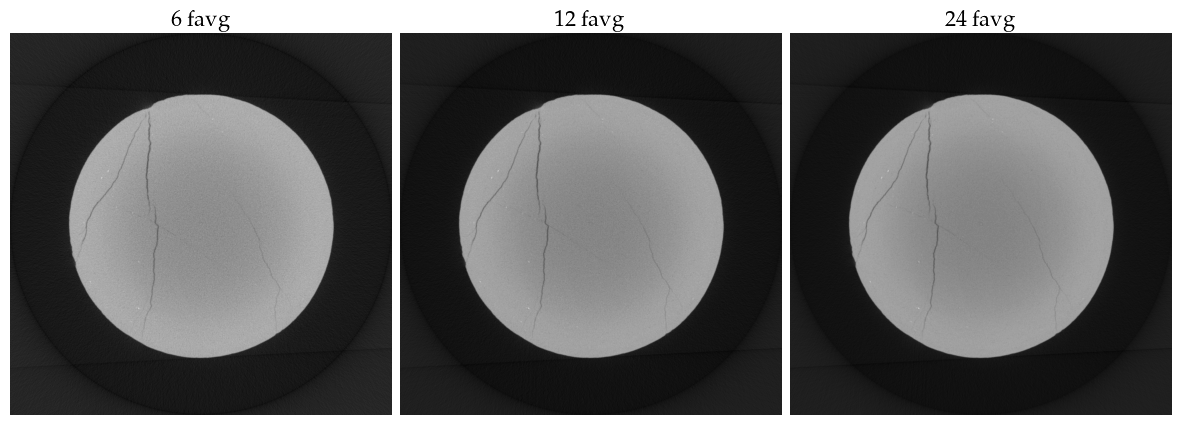

In [160]:
plot_slice_comparison(favg6_slice, favg12_slice, favg24_slice)

In [4]:


def plot_slice_histogram(hists:list, labels:list, xlabel="Pixel Value", ylabel="Probability Density", title="Gaussian Noise", savefig=False):

    choose_formatter(False)

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    for hist, label in zip(hists, labels):
        ax.hist(hist, bins=400, density=True, alpha=0.4, label=label)

    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf" )
    plt.show()

def plot_slice_histogram_grid(img, hists:list, labels:list, titles=["", ""], xlabel="Pixel Value", ylabel="Probability Density", savefile=None, savefig=False, roi= [[300,400], [300,400]]):

    choose_formatter(False)
        
    fig = plt.figure(figsize=(DEFAULT_FIGSIZE[0], DEFAULT_FIGSIZE[1]))
    gs = GridSpec(2,4, figure=fig, wspace=0, hspace=0.0)
    # axes = np.array([[fig.add_subplot(gs[j, i]) for i in range(n2)] for j in range(n1)]).reshape(-1)
    ax_img = fig.add_subplot(gs[:,0:2,])
    ax_hist = fig.add_subplot(gs[:,2:,])
    x1, x2 = roi[0]
    y1, y2 = roi[1]

    ax_img.imshow(img, cmap="gray")
    ax_img.plot([y1,y1], [x1,x2], "-", c="red", linewidth=2, alpha=0.75, label="RoI")
    ax_img.plot([y1,y2], [x1,x1], "-",c="red", linewidth=2, alpha=0.75, label="RoI")
    ax_img.plot([y2,y2], [x1,x2], "-",c="red", linewidth=2, alpha=0.75, label="RoI")
    ax_img.plot([y1,y2], [x2,x2], "-", c="red", linewidth=2, alpha=0.75, label="RoI")

    # ax_img.plot([y1,y2], [x1,x2], c="red", linewidth=2, alpha=0.75, label="RoI")
    ax_img.axis("off")
    ax_img = add_scalebar(ax_img)
    ax_img.set_title(titles[0])

    for hist, label in zip(hists, labels):
        ax_hist.hist(hist, bins=400, density=True, alpha=0.4, label=label)
    
    ax_hist.legend()
    ax_hist.set_title(titles[1])
    ax_hist.set_xlabel(xlabel)
    ax_hist.set_ylabel(ylabel)

    
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{savefile}.pdf", format="pdf" )

    plt.show()


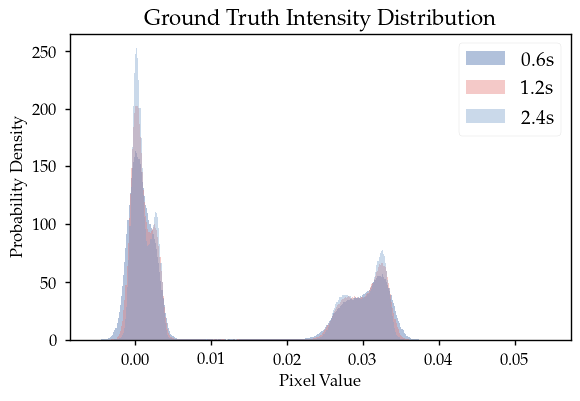

0.9973535884100049
0.9983942169566172
0.9968557908844566
30.48903279720613
33.035134873994714
30.027067782665565


In [204]:
diff6 = favg6_slice - favg24_slice
diff12 = favg12_slice - favg24_slice
diff126 = -(favg12_slice - favg6_slice)

# plot_noise_histogram(diff6.flatten(), diff12.flatten(), diff126.flatten(), title="Gaussian Noise Ground Truth", savefig=False)
plot_slice_histogram([favg6_slice.flatten(), favg12_slice.flatten(), favg24_slice.flatten()], [f"{0.6}s", f"{1.2}s", f"{2.4}s"], title="Ground Truth Intensity Distribution", savefig=False)


# diff126 = favg12_slice - favg6_slice

# plt.hist(diff126.flatten(), bins=400, density=True, alpha=0.5, label=fr"favg12 - favg6: $\sigma$={np.std(diff126):.5f}")
# plt.legend()
# plt.show()

x1, x2 = [300,500]
y1, y2 = [250,450]


print(utils.calc_ssim(favg6_slice[x1:x2, y1:y2], favg24_slice[x1:x2, y1:y2]))
print(utils.calc_ssim(favg24_slice[x1:x2, y1:y2], favg12_slice[x1:x2, y1:y2]))
print(utils.calc_ssim(favg12_slice[x1:x2, y1:y2], favg6_slice[x1:x2, y1:y2]))

print(utils.calc_psnr(favg6_slice[x1:x2, y1:y2], favg24_slice[x1:x2, y1:y2]))
print(utils.calc_psnr(favg24_slice[x1:x2, y1:y2], favg12_slice[x1:x2, y1:y2]))
print(utils.calc_psnr(favg12_slice[x1:x2, y1:y2], favg6_slice[x1:x2, y1:y2]))

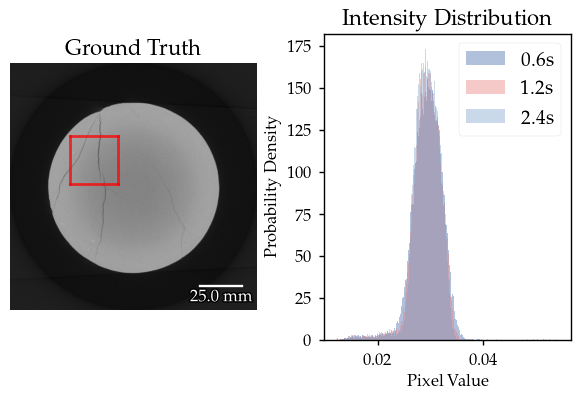

In [13]:
x1, x2 = [300,500]
y1, y2 = [250,450]



plot_slice_histogram_grid(crossections["favg24"]["gt"], [favg6_slice[x1:x2, y1:y2].flatten(), favg12_slice[x1:x2, y1:y2].flatten(), favg24_slice[x1:x2, y1:y2].flatten()], [f"{0.6}s", f"{1.2}s", f"{2.4}s"], titles=["Ground Truth", "Intensity Distribution"], savefile="ground_truths_exposure_comparison", savefig=True, roi=[[x1,x2], [y1,y2]])

In [6]:
# Now work with slices and do proper work


root = r"C:\Users\Bruker\Documents\Exposure"
# Load .npy files

x1, x2 = 1000, 1001
y1, y2 = 0, 1024
z1, z2 = 0, 1024

slice = [[x1, x2], [y1, y2], [z1, z2]]

names = [
    "limestoneV3_17_55_6favg",
    "limestoneV3_17_55_12favg",
    "limestoneV3_17_55_24favg",
]

crossections = {
    "favg6":  {"name": names[0] },
    "favg12": { "name": names[1]},
    "favg24": {"name": names[2]},
}

identifiers = [
    "gt",
    "Rec_0_1_fdk",
    "Rec_0_2_fdk",
    "Rec_0_3_fdk",
]
keys = [
    "gt",
    "17",
    "34",
    "51",
]

for k, v in crossections.items():
    for j,(id,key) in enumerate(zip(identifiers, keys)):

        load_name = f"{v['name']}_{identifiers[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
        load_path = os.path.join(root, load_name)
        crossections[k][key]= np.squeeze(np.load(load_path))



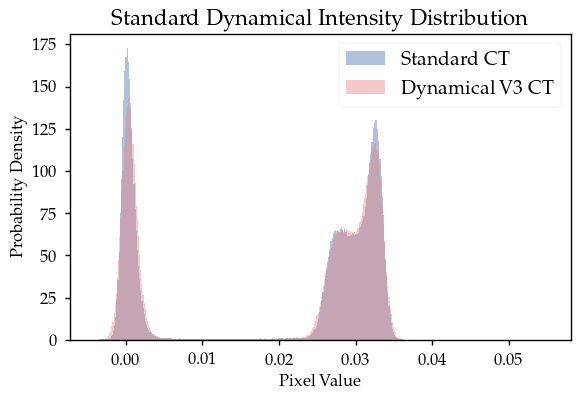

In [165]:
standard_CT = np.squeeze(np.load(os.path.join(root, "limestoneV3_1440_1_std_aligned_1000_1001_0_1024_0_1024.npy")))

# plot_slice_grid([standard_CT[125:-125,125:-125], crossections["favg12"]["gt"][125:-125,125:-125]], titles=["Standard CT", "Dynamical V3 CT"], savefile="standard_ct_dynamical_v3_ct", savefig=True)
#Possibly update with more projections V3. 

plot_slice_histogram([standard_CT[125:-125,125:-125].flatten(), crossections["favg12"]["gt"][125:-125,125:-125].flatten()], labels=["Standard CT", "Dynamical V3 CT"], title="Standard Dynamical Intensity Distribution", savefig=False)


In [7]:
plot_slice_grid([crossections["favg24"]["gt"],crossections["Ground Truth"]], savefile="Exposure_validation_gt", savefig=False)

KeyError: 'Ground Truth'

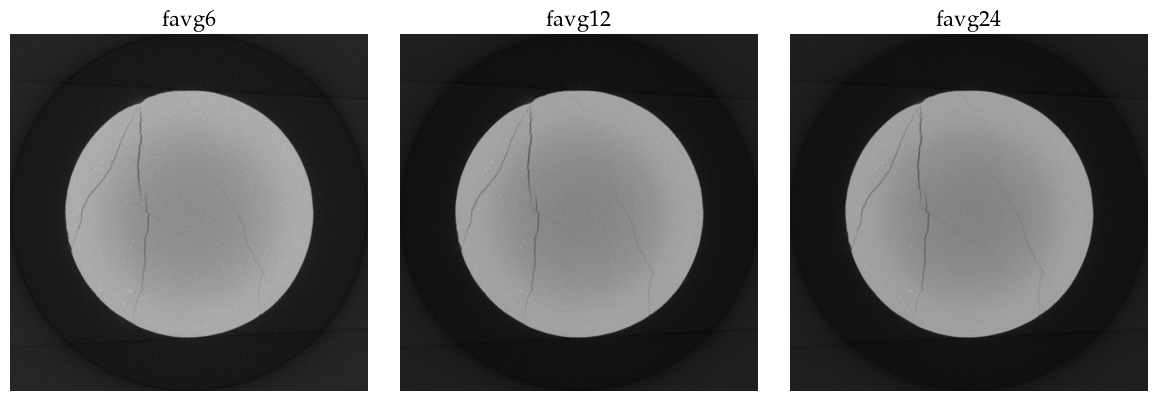

In [8]:
plot_slice_grid([crossections["favg6"]["gt"], crossections["favg12"]["gt"], crossections["favg24"]["gt"],], ["favg6", "favg12", "favg24", ], suptitle=None, savefig=False)

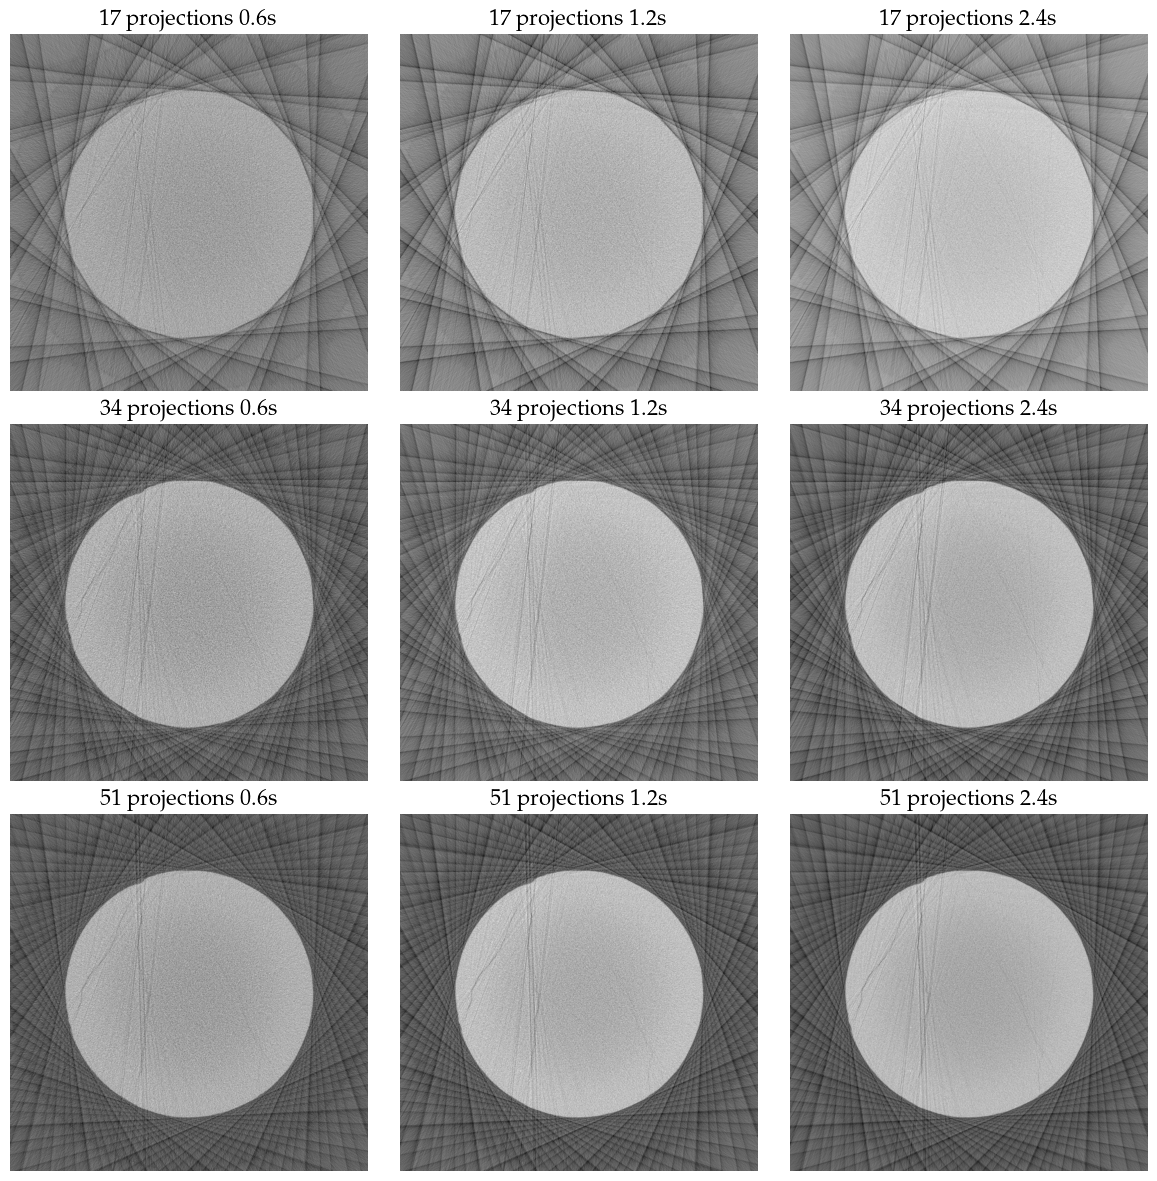

In [9]:
imgs = [ 
        crossections["favg6"]["17"], crossections["favg12"]["17"], crossections["favg24"]["17"],
        crossections["favg6"]["34"], crossections["favg12"]["34"], crossections["favg24"]["34"],
        crossections["favg6"]["51"], crossections["favg12"]["51"], crossections["favg24"]["51"],

        ]
labels = [
        "17 projections 0.6s", "17 projections 1.2s", "17 projections 2.4s",
        "34 projections 0.6s", "34 projections 1.2s", "34 projections 2.4s",
        "51 projections 0.6s", "51 projections 1.2s", "51 projections 2.4s",]

#RSD: Are we sure that the number of projections were wrong? Would a redo be beneficial?

plot_slice_grid(imgs, labels, suptitle=None, savefile="Undersampled_exposure_comparison", savefig=True)
# plot_slice_grid([crossections["favg6"]["51"], crossections["favg12"]["51"], crossections["favg24"]["51"]], ["favg6", "favg12", "favg24"], suptitle=None, savefig=False)

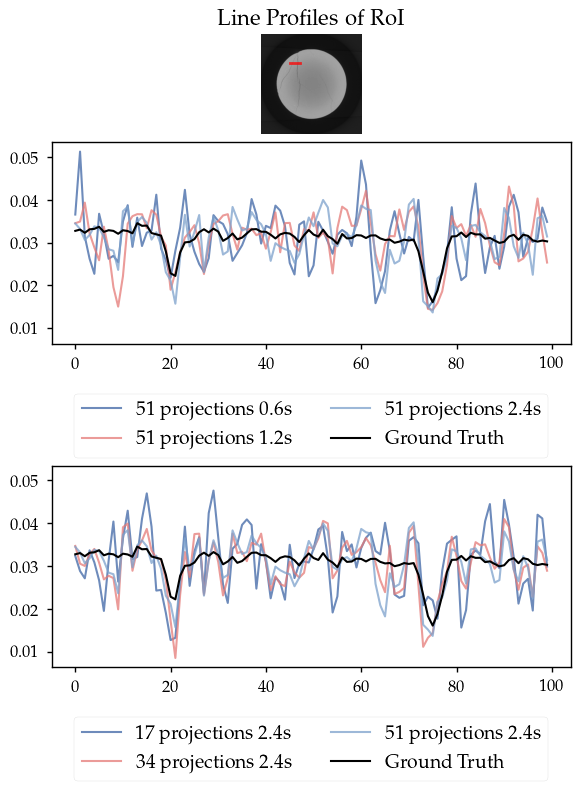

In [75]:
# plt.imshow(crossections["favg24"]["gt"], cmap="gray")
# plt.plot([300,400], [300,300], c="red", linewidth=2, alpha=0.75, label="ROI")
# plt.show()
# fig, ax = plt.subplots()

# for i, (img, lab) in enumerate(zip(imgs[6:], labels[6:])):

#     plt.plot(img[300,300:400], linewidth=1.5, alpha=0.75, label=lab)

# plt.plot(crossections["favg24"]["gt"][300,300:400], "-", linewidth=1.5, c="black", alpha=1, label="Ground Truth")
# plt.legend( bbox_to_anchor=(0.5, -0.2), loc="upper center",
#           ncol=2, fancybox=True, shadow=False)
# plt.show()

# fig, ax = plt.subplots()

# for i, (img, lab) in enumerate(zip(imgs[2::3], labels[2::3])):

#     plt.plot(img[300,300:400], linewidth=1.5, alpha=0.75, label=lab)
# plt.plot(crossections["favg24"]["gt"][300,300:400], "-", linewidth=1.5, c="black", alpha=1, label="Ground Truth")
# plt.legend( bbox_to_anchor=(0.5, -0.2), loc="upper center",
#           ncol=2, fancybox=True, shadow=False)
# plt.show()

def plot_line_profiles(imgs, labels, crossections, idxs=None, savefile=None, savefig=False):

    if idxs is None:
        x1,x2,y1,y2 = 300,300,300,400
    else:
        x1,x2,y1,y2 = idxs

    fig = plt.figure(figsize=(DEFAULT_FIGSIZE[0], DEFAULT_FIGSIZE[1]*2))
    gs = fig.add_gridspec(5, 1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1:3])
    ax3 = fig.add_subplot(gs[3:5])

    ax1.imshow(crossections["favg24"]["gt"], cmap="gray")
    ax1.plot([y1,y2], [x1,x2], c="red", linewidth=2, alpha=0.75, label="RoI")
    ax1.set_title("Line Profiles of RoI")
    ax1.set_axis_off()

    for i, (img, lab) in enumerate(zip(imgs[6:], labels[6:])):

        ax2.plot(img[x1,y1:y2], "-", linewidth=1.5, alpha=0.75, label=lab)

    ax2.plot(crossections["favg24"]["gt"][x1,y1:y2], "-", linewidth=1.5, c="black", alpha=1, label="Ground Truth")
    ax2.legend( bbox_to_anchor=(0.5, -0.2), loc="upper center",
                ncol=2, fancybox=True, shadow=False)

    for i, (img, lab) in enumerate(zip(imgs[2::3], labels[2::3])):

        ax3.plot(img[x1,y1:y2], "-", linewidth=1.5, alpha=0.75, label=lab)
    ax3.plot(crossections["favg24"]["gt"][x1,y1:y2], "-", linewidth=1.5, c="black", alpha=1, label="Ground Truth")
    ax3.legend( bbox_to_anchor=(0.5, -0.2), loc="upper center",
                ncol=2, fancybox=True, shadow=False)

    ax2.sharey(ax3)
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{savefile}.pdf", format="pdf" )

    plt.show()

plot_line_profiles(imgs, labels, crossections, idxs=[300,300,300,400], savefile="Line_profiles", savefig=True)

In [71]:
ssims = {}
psnrs = {}
mssims = {}

for k, v in crossections.items():

    ssims[k] = {}
    psnrs[k] = {}
    mssims[k] = {}
    for j,id in enumerate(keys):
        if id == "gt":
            continue
        ssims[k][id] = utils.calc_ssim(crossections["favg24"]["gt"][x1:x2, y1:y2], v[id][x1:x2, y1:y2], norm=True)
        psnrs[k][id] = utils.calc_psnr(crossections["favg24"]["gt"][x1:x2, y1:y2], v[id][x1:x2, y1:y2])
        mssims[k][id] = utils.calc_mssim(crossections["favg24"]["gt"][x1:x2, y1:y2], v[id][x1:x2, y1:y2])[0]

print(ssims)
print(psnrs)
print(mssims)

{'favg6': {'17': 0.20440161904925103, '34': 0.259928260778727, '51': 0.3028950114316387}, 'favg12': {'17': 0.23808622024711634, '34': 0.32575588731582567, '51': 0.3873265352855436}, 'favg24': {'17': 0.32875868704596095, '34': 0.4371847731590931, '51': 0.5225838102935803}}
{'favg6': {'17': 13.923913352253523, '34': 16.820660474522256, '51': 18.469796615129766}, 'favg12': {'17': 16.223582095084097, '34': 19.069715130707678, '51': 20.768822623296018}, 'favg24': {'17': 18.463232281539682, '34': 21.15795387616108, '51': 22.888974214060024}}
{'favg6': {'17': 0.14109967648983002, '34': 0.14333660900592804, '51': 0.15423612296581268}, 'favg12': {'17': 0.13740907609462738, '34': 0.16779333353042603, '51': 0.19095636904239655}, 'favg24': {'17': 0.20766688883304596, '34': 0.2546074092388153, '51': 0.31550320982933044}}


In [68]:
mssimgt1 = utils.calc_mssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg24"]["gt"][x1:x2, y1:y2])[0]
mssimgt2 = utils.calc_mssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg12"]["gt"][x1:x2, y1:y2])[0]
mssimgt3 = utils.calc_mssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg6"]["gt"][x1:x2, y1:y2])[0]
mssimgt4 = utils.calc_mssim(crossections["favg12"]["gt"][x1:x2, y1:y2], crossections["favg6"]["gt"][x1:x2, y1:y2])[0]

print(mssimgt1)
print(mssimgt2)
print(mssimgt3)
print(mssimgt4)

print(utils.calc_ssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg24"]["gt"][x1:x2, y1:y2]))
print(utils.calc_ssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg12"]["gt"][x1:x2, y1:y2]))
print(utils.calc_ssim(crossections["favg24"]["gt"][x1:x2, y1:y2], crossections["favg6"]["gt"][x1:x2, y1:y2]))
print(utils.calc_ssim(crossections["favg12"]["gt"][x1:x2, y1:y2], crossections["favg6"]["gt"][x1:x2, y1:y2]))

print(utils.calc_ssim(crossections["favg24"]["gt"], crossections["favg24"]["gt"]))
print(utils.calc_ssim(crossections["favg24"]["gt"], crossections["favg12"]["gt"]))
print(utils.calc_ssim(crossections["favg24"]["gt"], crossections["favg6"]["gt"]))
print(utils.calc_ssim(crossections["favg12"]["gt"], crossections["favg6"]["gt"]))

1.0
0.6298381090164185
0.5051925182342529
0.47625118494033813
1.0
0.9983942169566172
0.9973535884100049
0.9968557908844566
1.0
0.9992786498365109
0.9987558830268889
0.9985467672448338


In [69]:
def make_table(attr,name,exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4, int_lenght=1):

    tab = []
    #Initializing tabular env
    cs = ""
    for i in range(cols):
        cs += "c "
    tab.append("\\begin{tabular}{%s}"%cs)

    #creating header
    tab.append("\\hline")
    tab.append("\\multicolumn{%i}{c}{\\textbf{%s}} \\\\"%(cols, name))

    header_titles = "\\textbf{Projections} &\\multicolumn{%i}{c}{\\textbf{Exposures}} \\\\"%(cols-1)
    tab.append(header_titles)
    header = ""
    for i in range(len(exposures)):
        header += "& \\textbf{\\num{%s}%s} "%(exposures[i][:-1], exposures[i][-1])
    header += "\\\\"
    tab.append(header)
    tab.append("\\hline")

    for j, id in enumerate(projections):
        row = "\\textbf{%s} "%id
        for i, (k, v) in enumerate(attr.items()):
            if int_lenght == 1:
                row += "& \\num{%.3f}"%attr[k][id]
            elif int_lenght >=3:
                row += "& \\num{%.0f}"%attr[k][id]
            else:
                row += "& \\num{%.2f}"%attr[k][id]
        row += "\\\\"
        tab.append(row)

    #Finishing tabular env
    tab.append("\\hline")
    tab.append("\\end{tabular}")
    return tab


print("\\multicolumn{3}{c}{\\textbf{%s}} \\\\"%("Ruben"))
print("\\multicolumn{%i}{c}{\\textbf{%s}} \\\\"%(4, 'Ruben'))

\multicolumn{3}{c}{\textbf{Ruben}} \\
\multicolumn{4}{c}{\textbf{Ruben}} \\


In [72]:
tab = make_table(ssims, "SSIM", exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4)
for row in tab:
    print(row)
    pass

tab = make_table(psnrs, "PSNR", exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4, int_lenght=2)
for row in tab:
    print(row)



\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{SSIM}} \\
\textbf{Projections} &\multicolumn{3}{c}{\textbf{Exposures}} \\
& \textbf{\num{0.6}s} & \textbf{\num{1.2}s} & \textbf{\num{2.4}s} \\
\hline
\textbf{17} & \num{0.204}& \num{0.238}& \num{0.329}\\
\textbf{34} & \num{0.260}& \num{0.326}& \num{0.437}\\
\textbf{51} & \num{0.303}& \num{0.387}& \num{0.523}\\
\hline
\end{tabular}
\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{PSNR}} \\
\textbf{Projections} &\multicolumn{3}{c}{\textbf{Exposures}} \\
& \textbf{\num{0.6}s} & \textbf{\num{1.2}s} & \textbf{\num{2.4}s} \\
\hline
\textbf{17} & \num{13.92}& \num{16.22}& \num{18.46}\\
\textbf{34} & \num{16.82}& \num{19.07}& \num{21.16}\\
\textbf{51} & \num{18.47}& \num{20.77}& \num{22.89}\\
\hline
\end{tabular}


In [73]:
tab = make_table(mssims, "MSSIM", exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4)
for row in tab:
    print(row)

\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{MSSIM}} \\
\textbf{Projections} &\multicolumn{3}{c}{\textbf{Exposures}} \\
& \textbf{\num{0.6}s} & \textbf{\num{1.2}s} & \textbf{\num{2.4}s} \\
\hline
\textbf{17} & \num{0.141}& \num{0.137}& \num{0.208}\\
\textbf{34} & \num{0.143}& \num{0.168}& \num{0.255}\\
\textbf{51} & \num{0.154}& \num{0.191}& \num{0.316}\\
\hline
\end{tabular}


In [141]:
def V3_revolution(nproj, rr, avgf, fps, add_on=5 ):
    """
    Calculates scan time of one revolution with GoldenRatioV3
    nproj: number of projections
    rr: rotation rate in degrees per second
    avgf: number of frames to average over
    fps: frames per second
    add_on: number of seconds to add on to the scan time
    """

    exposure = nproj * avgf/fps
    rot = 360/rr
    scan_time = exposure + rot + add_on

    exposure_ratio = exposure/scan_time
    return scan_time, exposure_ratio

def V3_angles(nproj, nrevs, starting=0):
    angles = np.zeros((nrevs, nproj))

    golden_angle_sampling = lambda n, inc: np.mod((n * 1/((np.sqrt(5) - 1) / 2) * inc), inc)

    startings = golden_angle_sampling(np.arange(starting,nrevs), 360/nproj)

    linear_sampling = lambda s: np.linspace(s, s + 360, nproj, endpoint=False)

    return linear_sampling(startings).T

def V3_total_time( rr, avgf, fps, add_on=5,nproj=None, nrevs=None,total = None):

    if total is None:
        total = nproj * nrevs
    elif nproj is None:
        nproj = total//nrevs
    elif nrevs is None:
        nrevs = total//nproj       
    else:
        raise ValueError
    
    scan_time_rev, exposure_ratio = V3_revolution(nproj, rr, avgf, fps, add_on)

    return scan_time_rev * nrevs, exposure_ratio

In [154]:
rot_rate = 21
fps=10
add_on=0

nproj = 17
# nprojs = [17,34,51]

times = {}
ratios = {}
favgs = [6,12,24]
nrevs = [1,2,3]
# nrevs=1
keys=["17", "34", "51"]
eff_rr = lambda rr, p: rr/21 * 12.75016391 * np.exp(-0.01348855 * p)



for i, (k, v) in enumerate(crossections.items()):


    times[k] = {}
    ratios[k] = {}
    for j,id in enumerate(keys):
        if id == "gt":
            continue

        effective_rr = eff_rr(rot_rate, nproj*nrevs[j])
        times[k][id] = V3_total_time(effective_rr,favgs[i], fps, add_on, nproj=nproj*nrevs[j], nrevs=1)[0]
        ratios[k][id] = V3_total_time(effective_rr,favgs[i], fps, add_on, nproj=nproj*nrevs[j], nrevs=1)[1]

print(times)
print(ratios)

{'favg6': {'17': 45.7118077637781, '34': 65.0641248911709, '51': 86.77523234986884}, 'favg12': {'17': 55.9118077637781, '34': 85.4641248911709, '51': 117.37523234986885}, 'favg24': {'17': 76.31180776377809, '34': 126.2641248911709, '51': 178.57523234986886}}
{'favg6': {'17': 0.22313709518358732, '34': 0.31353683822109235, '51': 0.35263518369647157}, 'favg12': {'17': 0.3648603187038415, '34': 0.4773932928226233, '51': 0.5214047186511779}, 'favg24': {'17': 0.5346485844798187, '34': 0.6462643293994423, '51': 0.6854253996443975}}


In [155]:
tab = make_table(times, "Scan time [s]", exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4, int_lenght=3)
for row in tab:
    print(row)

tab = make_table(ratios, "Exposure ratio", exposures=["0.6s", "1.2s", "2.4s"], projections=["17", "34", "51"], cols=4, int_lenght=1)
for row in tab:
    print(row)

\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{Scan time [s]}} \\
\textbf{Projections} &\multicolumn{3}{c}{\textbf{Exposures}} \\
& \textbf{\num{0.6}s} & \textbf{\num{1.2}s} & \textbf{\num{2.4}s} \\
\hline
\textbf{17} & \num{46}& \num{56}& \num{76}\\
\textbf{34} & \num{65}& \num{85}& \num{126}\\
\textbf{51} & \num{87}& \num{117}& \num{179}\\
\hline
\end{tabular}
\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{Exposure ratio}} \\
\textbf{Projections} &\multicolumn{3}{c}{\textbf{Exposures}} \\
& \textbf{\num{0.6}s} & \textbf{\num{1.2}s} & \textbf{\num{2.4}s} \\
\hline
\textbf{17} & \num{0.223}& \num{0.365}& \num{0.535}\\
\textbf{34} & \num{0.314}& \num{0.477}& \num{0.646}\\
\textbf{51} & \num{0.353}& \num{0.521}& \num{0.685}\\
\hline
\end{tabular}
